<a href="https://colab.research.google.com/github/GaetanAm/Sentiment-Analysis-and-Impact-on-Financial-Markets/blob/main/notebooks/Stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files

# Téléchargez le fichier directement dans l'environnement
uploaded = files.upload()


Saving tesla_news.csv to tesla_news.csv


In [7]:
import pandas as pd

# Charger les données
file_path = "tesla_news.csv"  # Remplacez par le chemin de votre fichier
df = pd.read_csv(file_path)

# Vérification des données
print(df.head())
print(df.info())


                                               title publishedAt sentiment
0  Tesla police cruiser, Trump voters love solar,...  2024-11-07  Positive
1  Dow Jones Surges On Trump Win. What To Do As S...  2024-11-07  Positive
2  Trump Lackey Elon Musk's Biggest Controversies...  2024-11-07  Negative
3  How Elon Musk’s $130 million investment in Tru...  2024-11-07  Positive
4                                          [Removed]  2024-11-07   Neutral
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4381 entries, 0 to 4380
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4380 non-null   object
 1   publishedAt  4381 non-null   object
 2   sentiment    4381 non-null   object
dtypes: object(3)
memory usage: 102.8+ KB
None


In [ ]:
!pip install yfinance


In [8]:
import yfinance as yf

# Récupérer les données historiques pour Tesla
tesla = yf.Ticker("TSLA")
stock_data = tesla.history(start="2024-11-07", end="2024-12-06")  # Ajuster les dates si nécessaire

# Garder uniquement les colonnes nécessaires
stock_data = stock_data[['Close']]  # On utilise le prix de clôture
stock_data.reset_index(inplace=True)
stock_data.rename(columns={'Date': 'publishedAt', 'Close': 'stock_price'}, inplace=True)
print(stock_data.head())


                publishedAt  stock_price
0 2024-11-07 00:00:00-05:00   296.910004
1 2024-11-08 00:00:00-05:00   321.220001
2 2024-11-11 00:00:00-05:00   350.000000
3 2024-11-12 00:00:00-05:00   328.489990
4 2024-11-13 00:00:00-05:00   330.239990


In [9]:
# Convertir les dates pour correspondre
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
stock_data['publishedAt'] = pd.to_datetime(stock_data['publishedAt'])

# Convertir en datetime sans fuseau horaire
df['publishedAt'] = pd.to_datetime(df['publishedAt']).dt.tz_localize(None)
stock_data['publishedAt'] = pd.to_datetime(stock_data['publishedAt']).dt.tz_localize(None)

print(df['publishedAt'].dtype)
print(stock_data['publishedAt'].dtype)

# Fusionner les données
merged_data = pd.merge(df, stock_data, on='publishedAt', how='inner')
print(merged_data.head())

datetime64[ns]
datetime64[ns]
                                               title publishedAt sentiment  \
0  Tesla police cruiser, Trump voters love solar,...  2024-11-07  Positive   
1  Dow Jones Surges On Trump Win. What To Do As S...  2024-11-07  Positive   
2  Trump Lackey Elon Musk's Biggest Controversies...  2024-11-07  Negative   
3  How Elon Musk’s $130 million investment in Tru...  2024-11-07  Positive   
4                                          [Removed]  2024-11-07   Neutral   

   stock_price  
0   296.910004  
1   296.910004  
2   296.910004  
3   296.910004  
4   296.910004  


In [10]:
# Encoder les sentiments
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
merged_data['sentiment'] = merged_data['sentiment'].map(sentiment_map)

# Diviser les données
from sklearn.model_selection import train_test_split

X = merged_data[['sentiment']]  # Variable explicative
y = merged_data['stock_price']  # Variable cible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [11]:
print(merged_data.head())

                                               title publishedAt  sentiment  \
0  Tesla police cruiser, Trump voters love solar,...  2024-11-07        1.0   
1  Dow Jones Surges On Trump Win. What To Do As S...  2024-11-07        1.0   
2  Trump Lackey Elon Musk's Biggest Controversies...  2024-11-07       -1.0   
3  How Elon Musk’s $130 million investment in Tru...  2024-11-07        1.0   
4                                          [Removed]  2024-11-07        0.0   

   stock_price  
0   296.910004  
1   296.910004  
2   296.910004  
3   296.910004  
4   296.910004  


In [12]:
print(merged_data['sentiment'].unique())


[ 1. -1.  0. nan]


In [13]:
print(X_test.isnull().sum())  # Compte des NaN par colonne
print(X_test[X_test.isnull().any(axis=1)])  # Lignes contenant des NaN


sentiment    1
dtype: int64
     sentiment
315        NaN


In [14]:
print(X_test[X_test.isnull().any(axis=1)])


     sentiment
315        NaN


In [15]:
X_test = X_test.dropna()
y_test = y_test[X_test.index]  # Ajuster y_test pour correspondre aux indices mis à jour


In [16]:
print(X_test.isnull().sum())


sentiment    0
dtype: int64


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 292.4435299996879
R^2 Score: -0.001134833974736127


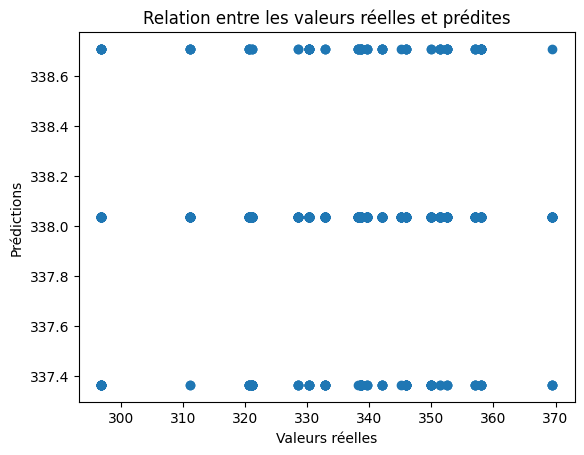

In [18]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Relation entre les valeurs réelles et prédites")
plt.show()


In [19]:
from sklearn.ensemble import RandomForestRegressor

# Entraîner un modèle Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")


Random Forest MSE: 292.4204019931662
Random Forest R^2 Score: -0.0010556588499890385


In [20]:
import numpy as np

# Ajouter sentiment et stock_price dans un DataFrame
data_for_corr = merged_data[['sentiment', 'stock_price']]

# Calcul de la corrélation
correlation = data_for_corr.corr()
print(correlation)


             sentiment  stock_price
sentiment     1.000000    -0.025003
stock_price  -0.025003     1.000000


In [54]:
# Calcul des variations de prix
merged_data['price_change'] = merged_data['stock_price'].diff().fillna(0)

# Corrélation entre sentiments et variations
data_for_corr = merged_data[['sentiment', 'price_change']]
correlation = data_for_corr.corr()
print(correlation)


              sentiment  price_change
sentiment      1.000000      0.041904
price_change   0.041904      1.000000


In [22]:
# Filtrer les données pour garder uniquement les sentiments positifs ou négatifs
filtered_data = merged_data[merged_data['sentiment'] != 0]

# Vérifier les nouvelles dimensions des données
print("Taille après filtrage :", filtered_data.shape)
print(filtered_data['sentiment'].value_counts())


Taille après filtrage : (1060, 5)
sentiment
 1.0    594
-1.0    465
Name: count, dtype: int64


In [23]:
# Corrélation sur les données filtrées
data_for_corr_filtered = filtered_data[['sentiment', 'stock_price']]
correlation_filtered = data_for_corr_filtered.corr()
print(correlation_filtered)


             sentiment  stock_price
sentiment     1.000000    -0.041215
stock_price  -0.041215     1.000000


In [28]:
# Redéfinir X et y
X = filtered_data[['sentiment']]
y = filtered_data['stock_price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Taille de X_train :", X_train.shape)
print("Taille de y_train :", y_train.shape)


Taille de X_train : (848, 1)
Taille de y_train : (848,)


In [33]:
print(filtered_data['sentiment'].unique())

[ 1. -1. nan]


In [51]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Ajuster y_train pour correspondre à X_train



In [52]:
print(X_train.isnull().sum())  # Devrait afficher 0


sentiment    0
dtype: int64


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 353.237391344725
R^2 Score: -0.013829281090233625


In [ ]:
# Calcul des variations de prix
merged_data['price_change'] = merged_data['stock_price'].diff().fillna(0)

# Corrélation entre sentiments et variations
data_for_corr = merged_data[['sentiment', 'price_change']]
correlation = data_for_corr.corr()
print(correlation)